<a href="https://colab.research.google.com/github/carlocamilloni/Structural-Bioinformatics/blob/main/Notebooks/t03_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Molecular Dynamics simulation with GROMACS

The aim of this experience is to run  Molecular Dynamics simulations of simple systems and analyze them, we will focus on water and alanine dipeptide.

The reference lectures are:

*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/02_StochasticMolecules.pdf
*   https://github.com/carlocamilloni/Structural-Bioinformatics/blob/main/Notes/03_MolecularDynamics.pdf



## Preliminary setup

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


Make a new folder for this task using the menus on the left side: for example in /drive/MyDrive/Structural_Bioinformatics make a folder named Task3.

In [2]:
# set the path to your local task folder
local_path='/content/drive/MyDrive/Structural_Bioinformatics/Task3'
%cd {local_path}

/content/drive/MyDrive/Structural_Bioinformatics/Task3


In [3]:
# install gromacs
# gromacs is a molecular dynamics open source software
!apt update
!apt install gromacs

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,473 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,389 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 https://r2u.s

In [4]:
# test the gromacs executable
!gmx

                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Teem

In [5]:
# make a copy of the GitHub structural bioinformatics repository
%pwd
%cd ..
!git clone https://github.com/carlocamilloni/Structural-Bioinformatics.git sb --depth 1

/content/drive/MyDrive/Structural_Bioinformatics
fatal: destination path 'sb' already exists and is not an empty directory.


All GROMACS tools are modules of a binary named "gmx". To get help about any GROMACS module, you can invoke either of the following commands:

gmx help (module)

or

gmx (module) -h

where (module) is replaced by the actual name of the command you're trying to issue. A full list of GROMACS modules can be printed by

gmx help commands

###Units

Basic units in GROMACS are

Time: ps

Space: nm

Energy: kJ/mol


## Molecular Dynamics of Lysozyme in solution

Here you will setup a simulation for hen egg-white lysozyme, a widely study system in structural biology. Its crystal structure can be find on the PDB as 1AKI

In [19]:
# Download the structure from the PDB
!wget https://files.rcsb.org/view/1AKI.pdb

--2025-10-27 13:14:30--  https://files.rcsb.org/view/1AKI.pdb
Resolving files.rcsb.org (files.rcsb.org)... 13.249.141.37, 13.249.141.40, 13.249.141.118, ...
Connecting to files.rcsb.org (files.rcsb.org)|13.249.141.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘1AKI.pdb’

1AKI.pdb                [ <=>                ] 113.67K  --.-KB/s    in 0.06s   

2025-10-27 13:14:30 (1.77 MB/s) - ‘1AKI.pdb’ saved [116397]



In [20]:
# Remove structural waters
!grep -v HOH 1AKI.pdb > 1AKI_clean.pdb

At this point one has to select the force field and the water model to be used in the simulation and prepare what is called the topology of the system, that is a file describing all the interactions as they appear in our system of interest. In GROMACS this is done using `pdb2gmx` and selecting some options. Becasue it is not possible to select options in `colab` we will need to provide them as flags:

In [28]:
# here we use charmm27 as a force field and tip3p as the water model
# we do not set protonation states so that by default we use pH 7
!gmx pdb2gmx -f 1AKI_clean.pdb -o 1AKI_processed.gro -ignh -water tip3p -ff "charmm27"

             :-) GROMACS - gmx pdb2gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [31]:
# some new files have been created, in particular:
# topol.top is the TOPOLOGY file
# 1AKI_processed.gro is the initial structure in default GROMACS format
%ls

 0-em-steep.mdp           '#md.log.1#'               md-water.trr
 1AKI_clean.pdb           '#md.log.2#'              '#md-water.trr.1#'
 1AKI.pdb                  mdout.mdp                '#md-water.trr.2#'
 1AKI_processed.gro        md-water.cpt              md-water.xtc
'#1AKI_processed.gro.1#'   md-water.edr             '#md-water.xtc.1#'
 conf.gro                 '#md-water.edr.1#'        '#md-water.xtc.2#'
'#conf.gro.1#'            '#md-water.edr.2#'         npt-water.mdp
'#conf.gro.2#'             md-water.gro              posre.itp
'#conf.gro.3#'            '#md-water.gro.1#'        '#posre.itp.1#'
 confout.gro              '#md-water.gro.2#'         rdf_293.xvg
'#confout.gro.1#'          md-water.log              rdf.xvg
'#confout.gro.2#'         '#md-water.log.1#'         spc216.gro
 em.tpr                   '#md-water.log.2#'         topol.top
'#em.tpr.1#'               md-water-nobpc.xtc       '#topol.top.1#'
'#em.tpr.2#'              '#md-water-nobpc.xtc.1#'  '#topol.top.2

The following step is to place the structure in a BOX that should be large enough to avoid self-interactions of the molecule through the sides but small enough to maximise performances. We set the box using `editconf`.

In [32]:
# set a dodecahedron like box whose distance from the protein is at least 1.2 nm
!gmx editconf -f 1AKI_processed.gro -bt dodecahedron -d 1.2 -o 1AKI_box.gro

             :-) GROMACS - gmx editconf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff           

Then we can solvate the protein using `solvate`:

In [33]:
# here we use spc216.gro coordinates of the solvent that are equivalent to tip3p
!gmx solvate -cp 1AKI_box -cs spc216.gro -p topol.top -o 1AKI_solv.gro

             :-) GROMACS - gmx solvate, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

You should see from the log something like 8700 water molecule that have been added to the system.

Next step is to add salts, to do this we need to calculate eletrostatic interactions and so we need to process the topology and structure and generate a GROMACS MD simulation input file. This is done using `grompp` and a molecular dynamics paratemers `.mdp` file.

## Molecular Dynamics of water

In the following you will setup a MD simulation of a small water box and calculate some water property:

### system preparation

In [6]:
# copy a water box file with 216 molecules in a cubic box:
%cd {local_path}
# create a folder named water
%mkdir water
# move to the folder
%cd water
# copy a file to here (.)
%cp /usr/share/gromacs/top/spc216.gro .

/content/drive/MyDrive/Structural_Bioinformatics/Task3
mkdir: cannot create directory ‘water’: File exists
/content/drive/MyDrive/Structural_Bioinformatics/Task3/water


The first step is to generate the

*   Starting coordinates file
*   Topology file that includes the choice of the force field

this is done in gromacs using the tool `pdb2gmx`:

In [7]:
# here we are using amber03 as a force field and spce as the water model:
!gmx pdb2gmx -f spc216.gro -ff amber03 -water spce

             :-) GROMACS - gmx pdb2gmx, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [8]:
%ls

 0-em-steep.mdp     mdout.mdp                '#md-water.trr.1#'
 conf.gro           md-water.cpt              md-water.xtc
'#conf.gro.1#'      md-water.edr             '#md-water.xtc.1#'
'#conf.gro.2#'     '#md-water.edr.1#'         npt-water.mdp
'#conf.gro.3#'      md-water.gro              rdf_293.xvg
 confout.gro       '#md-water.gro.1#'         rdf.xvg
'#confout.gro.1#'   md-water.log              spc216.gro
 em.tpr            '#md-water.log.1#'         topol.top
'#em.tpr.1#'        md-water-nobpc.xtc       '#topol.top.1#'
 ener.edr          '#md-water-nobpc.xtc.1#'  '#topol.top.2#'
'#ener.edr.1#'     '#md-water-nobpc.xtc.2#'  '#topol.top.3#'
 energy.xvg         md-water_prev.cpt         traj.trr
 index.ndx          md-water.tpr             '#traj.trr.1#'
 md.log            '#md-water.tpr.1#'
'#md.log.1#'        md-water.trr


There should be two new files:

* conf.gro: starting coordinates in gromacs format
* topol.top: topology file including relevant parameters and force-field choice.

If you open topol.top (these are all text files) you can see that is very simple in this case.

In principle now we should generate the box, but in this case we are already starting from a box of water molecules, you can see the box size at the bottom of the conf.gro file:

In [9]:
!tail conf.gro

  214HOH     OW  640  -0.269   0.221   0.882
  214HOH    HW1  641  -0.353   0.220   0.936
  214HOH    HW2  642  -0.267   0.304   0.826
  215HOH     OW  643   0.039  -0.785   0.300
  215HOH    HW1  644   0.138  -0.796   0.291
  215HOH    HW2  645  -0.001  -0.871   0.332
  216HOH     OW  646   0.875  -0.216   0.337
  216HOH    HW1  647   0.798  -0.251   0.283
  216HOH    HW2  648   0.843  -0.145   0.399
   1.86206   1.86206   1.86206


box: 1.86206   1.86206   1.86206

This means that is a cubic box of side 1.862 nm etc

### energy minimization:

In [10]:
# to perform simulations we also need a simulation parameter file
%cp ../../sb/Data/md/mdps/0-em-steep.mdp {local_path}/water

In [11]:
#then we need to generate a simulation package file that put togheter the starting configuration, the topology and the simulation parameter file:
!gmx grompp -f 0-em-steep.mdp -c conf.gro -p topol.top -o em.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [12]:
#run the energy minimization:
!gmx mdrun -s em.tpr -v

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

### MD

In [13]:
#now we are ready to setup the first simple MD
%cp ../../sb/Data/md/mdps/npt-water.mdp {local_path}/water

The file you have just copied includes the specific parameter of the simulation you are going to run, like the length of the simulation, the temperature, ecc.

In the left menu you can double click on the file to read it/edit it ecc.

In [14]:
#preparation
!gmx grompp -f npt-water -c confout -p topol -o md-water.tpr

              :-) GROMACS - gmx grompp, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

In [15]:
# run the simulation, this will take 2-3 minutes
!gmx mdrun -v -deffnm md-water

              :-) GROMACS - gmx mdrun, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

### Visualisation

Once the simulation is ended you should have few more files:

In [16]:
%ls

 0-em-steep.mdp    '#md.log.2#'              '#md-water.tpr.2#'
 conf.gro           mdout.mdp                 md-water.trr
'#conf.gro.1#'      md-water.cpt             '#md-water.trr.1#'
'#conf.gro.2#'      md-water.edr             '#md-water.trr.2#'
'#conf.gro.3#'     '#md-water.edr.1#'         md-water.xtc
 confout.gro       '#md-water.edr.2#'        '#md-water.xtc.1#'
'#confout.gro.1#'   md-water.gro             '#md-water.xtc.2#'
'#confout.gro.2#'  '#md-water.gro.1#'         npt-water.mdp
 em.tpr            '#md-water.gro.2#'         rdf_293.xvg
'#em.tpr.1#'        md-water.log              rdf.xvg
'#em.tpr.2#'       '#md-water.log.1#'         spc216.gro
 ener.edr          '#md-water.log.2#'         topol.top
'#ener.edr.1#'      md-water-nobpc.xtc       '#topol.top.1#'
'#ener.edr.2#'     '#md-water-nobpc.xtc.1#'  '#topol.top.2#'
 energy.xvg        '#md-water-nobpc.xtc.2#'  '#topol.top.3#'
 index.ndx          md-water_prev.cpt         traj.trr
 md.log             md-water.tpr       

*   md-water.xtc: trajectory file
*   md-water.edr: energy file including all the information about energy
*   md-water.gro: last frame of the trajectory
*   md-water.cpt: checkpoint file for exact restart

You can look at the trajectory using VMD on your laptop, first load a `conf.gro` then from the menu FILE choose *Load Data Into Molecule* and select the `md-water.xtc` file, this will add all the trajectory frames. You may see something like this:

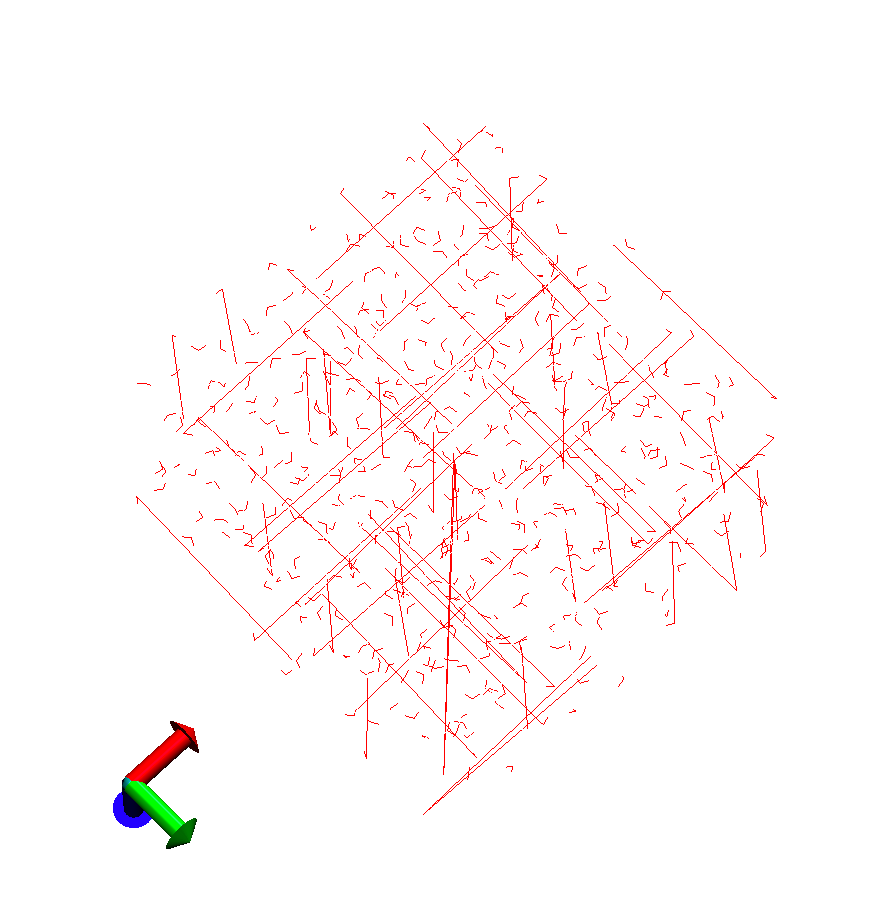

You remember the “PERIODIC BOUNDARY CONDITIONS”? A molecule of water can be cut across the sides of the box. For the purpose of visualisation, we can remove this effect:

In [17]:
# here trjconv takes in input md-water.xtc (-f) and the simulation ready file (-s md-water.tpr)
# fix molecules to always be whole through covalent interactions (-pbc mol)
# write a corrected trajctory (-o md-water-nopbc.xtc)
!echo -e "0\n" | gmx trjconv -f md-water.xtc -s md-water.tpr -pbc mol -o md-water-nobpc.xtc

             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            

This command is a bit complicated because the notebooks are not interactive so if we need to select an option, we need to tell it to the program as above:

`echo -e “0\n” |` -> this means after the program that follow is started press “0”.

Anyway, now you have one more file `md-water-nopbc.xtc` that is the trajectory with molecules that are not broken across PBC. Close VMD and reopen it. Now we can start to analyse the trajectory

### Analysis

**DENSITY**, **HEAT CAPACITY** and **ENTALPY OF VAPORISATION**.



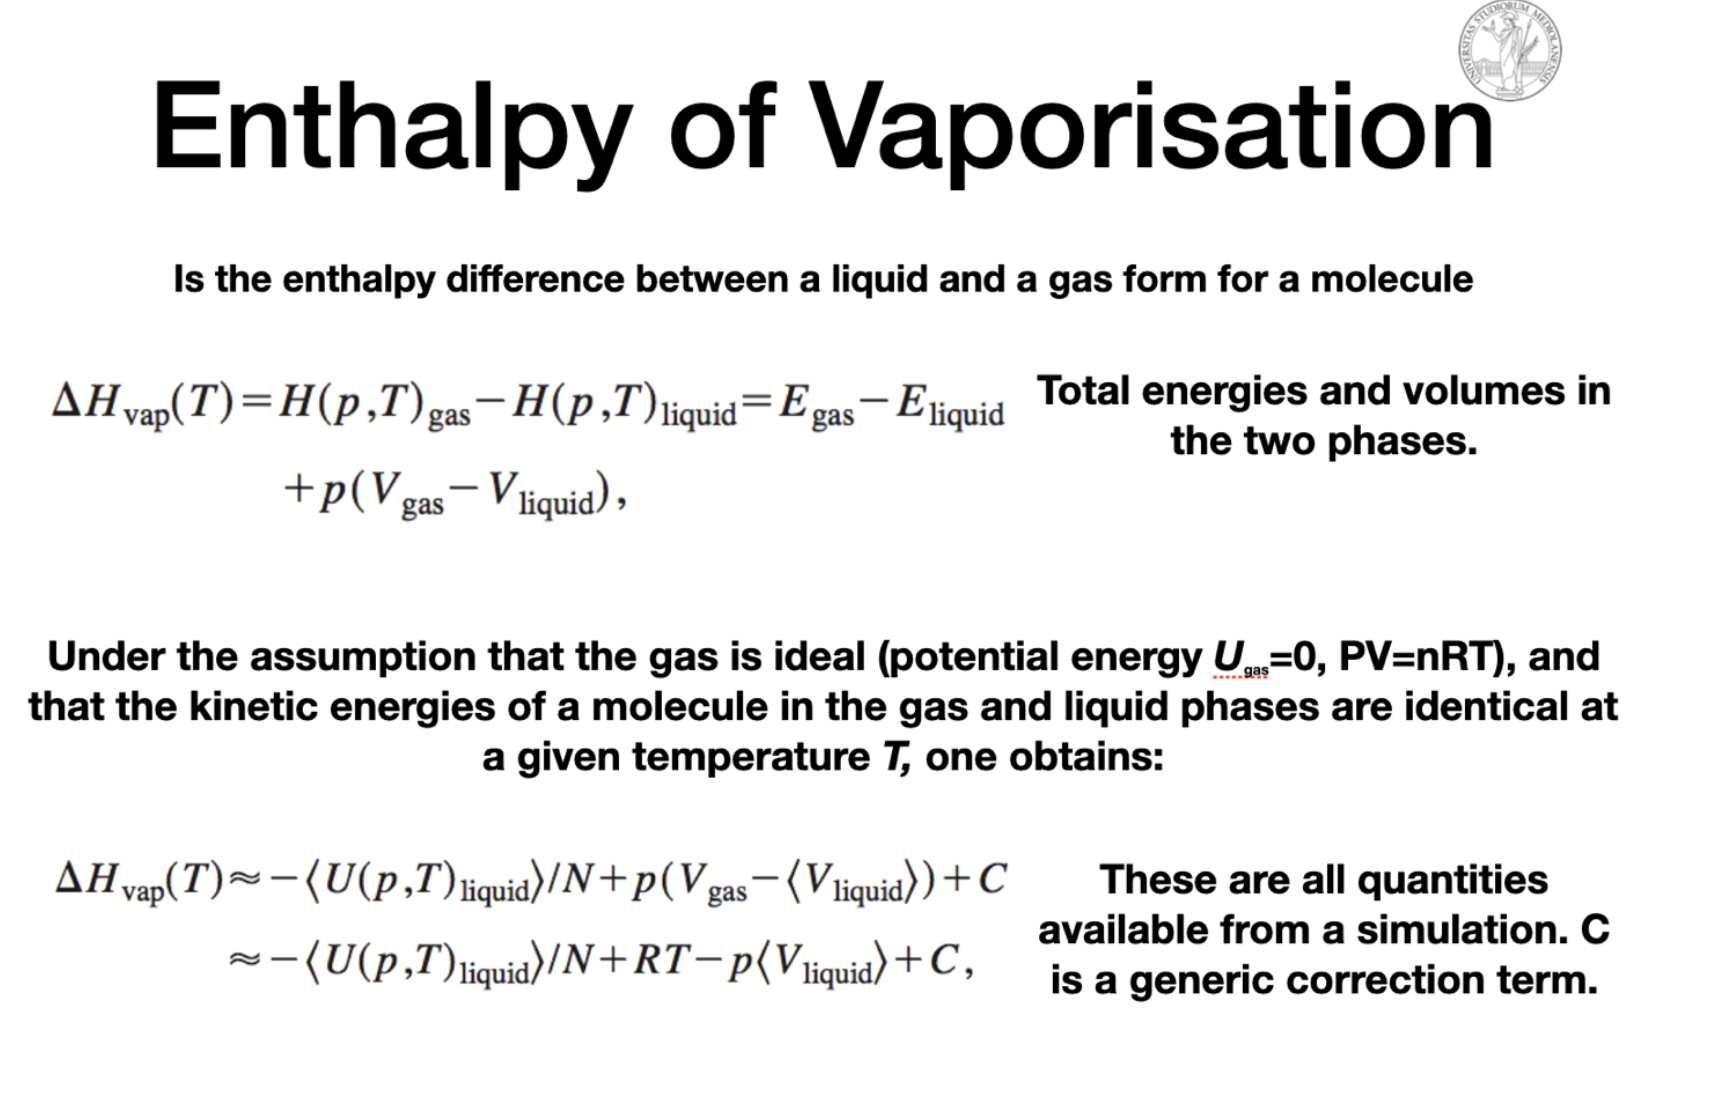

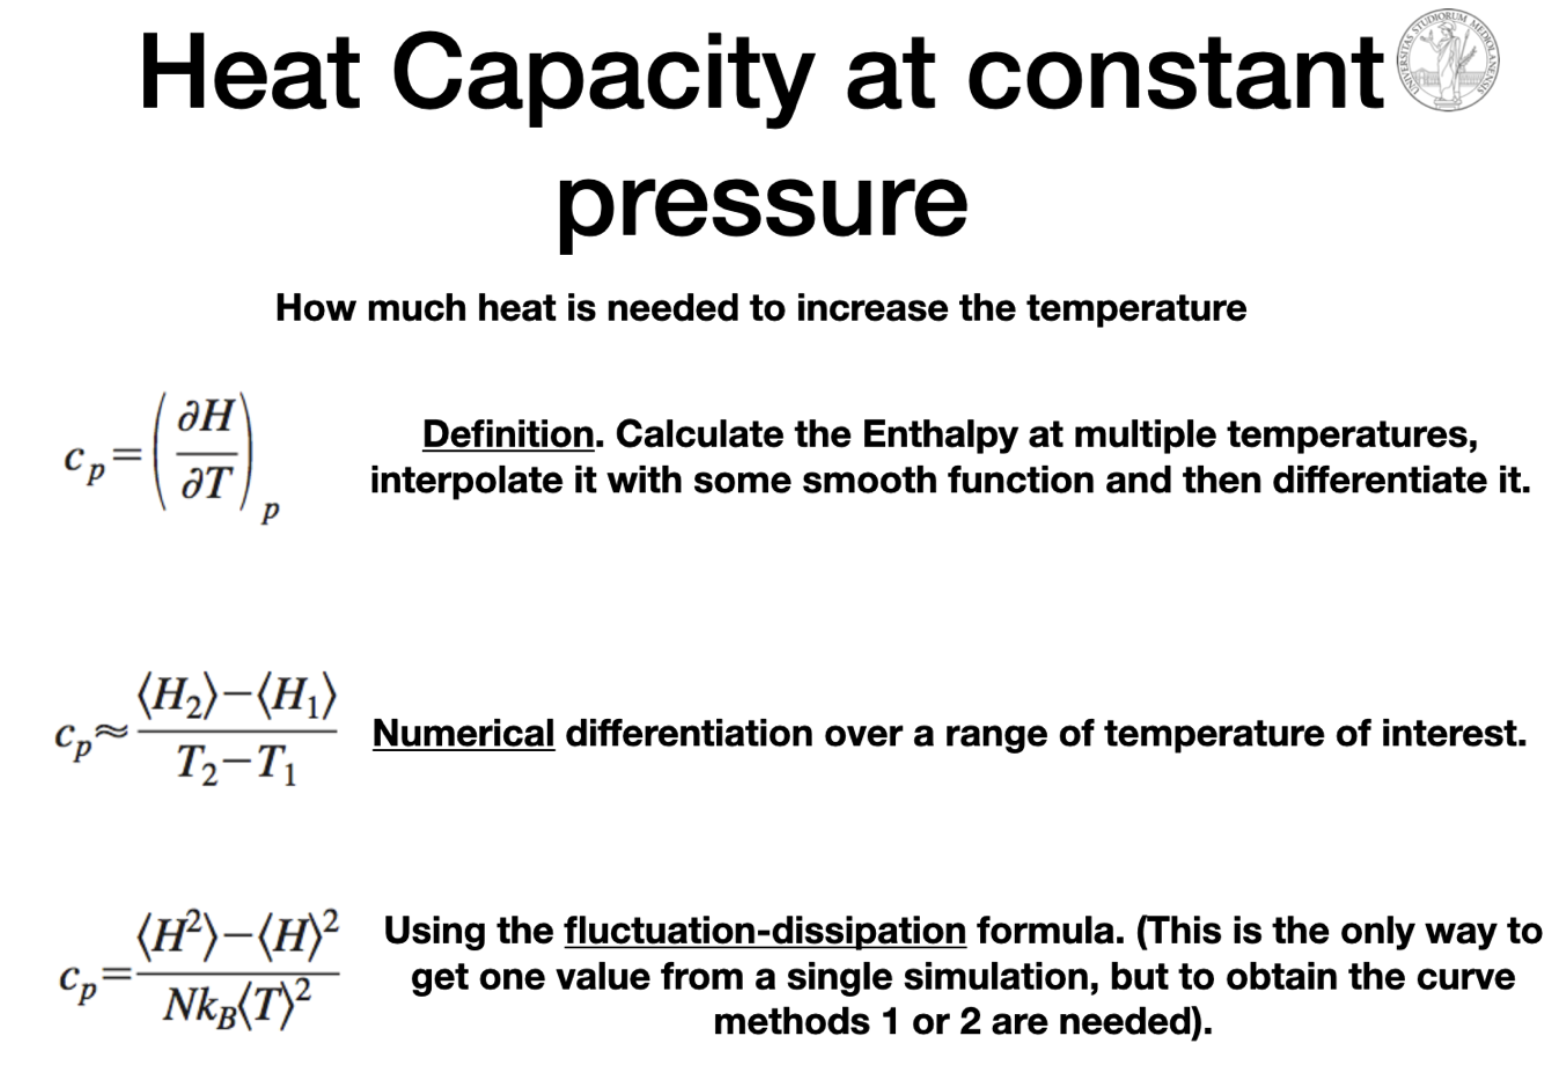

to calculate them we can again use a GROMACS module:

In [ ]:
!echo -e "5\n15\n16\n18\n" | gmx energy -f md-water.edr -s md-water


This will generate a file named `energy.xvg` with as many columns as the properties selected. Here:
`-nmol 216` indicates how many molecules are in the simulations
`-fluct_props` tell the program to calculate fluctuations (see my slides on how to calculate some of the resulting properties).

This will calculate the density over time, total energy, enthalpy and temperature and derive simple properties from it (heat capacity and enthalpy of vaporisation).

Try to generate the plot for all of them and compare the result with the number reported in the tables, be careful about the units.

To plot more than one set in the same plot you can do something like this:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]
y3=[]
y4=[]

with open('energy.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))
        y2.append(float(row.split()[2]))
        y3.append(float(row.split()[3]))
        y4.append(float(row.split()[4]))


# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2,2)
figure.set_size_inches(18.5, 10.5)

axis[0,0].plot(x, y1)
axis[0,0].set_ylabel("Potential Energy (kj/mol)")
axis[0,0].set_xlabel("Time (ps)")

axis[1,0].plot(x, y2)
axis[1,0].set_ylabel("Volume (nm$^3$)")
axis[1,0].set_xlabel("Time (ps)")

axis[0,1].plot(x, y3)
axis[0,1].set_ylabel("Density (kg/m$^3$)")
axis[0,1].set_xlabel("Time (ps)")

axis[1,1].plot(x, y4)
axis[1,1].set_ylabel("Entalphy (kj/mol)")
axis[1,1].set_xlabel("Time (ps)")

plt.show()


Now we calculate the radial distribution function

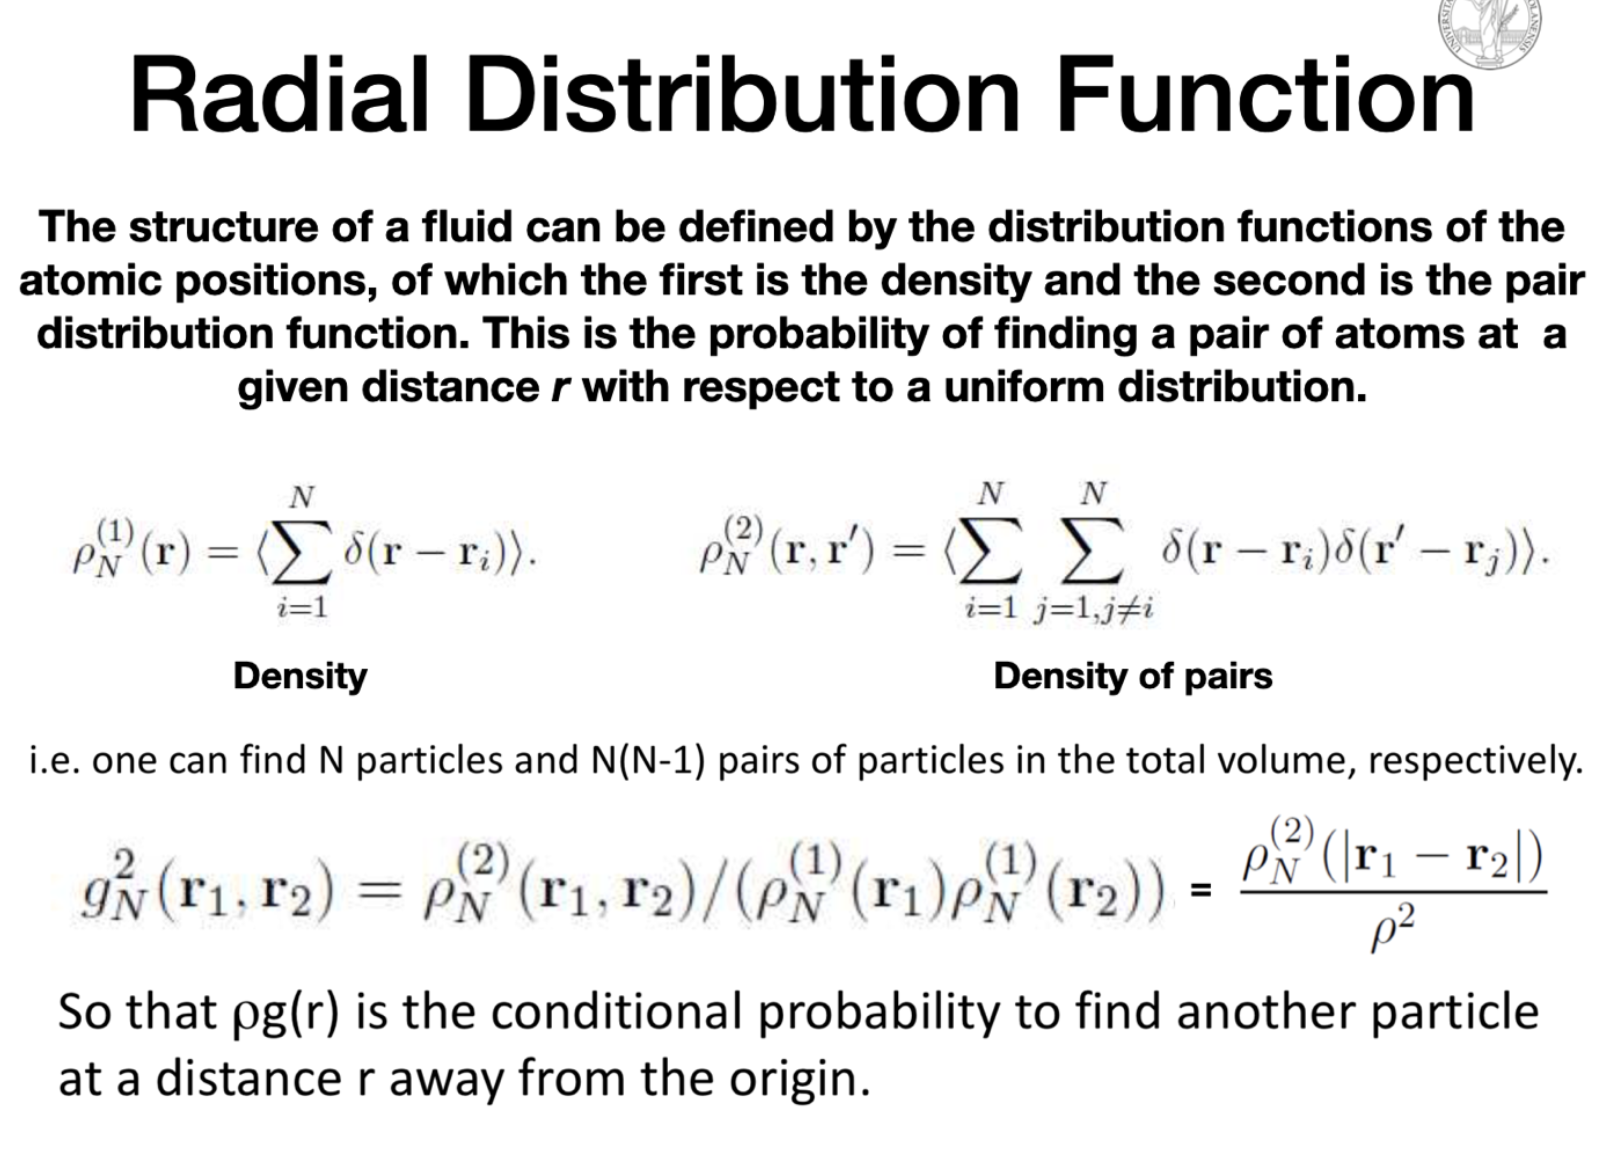

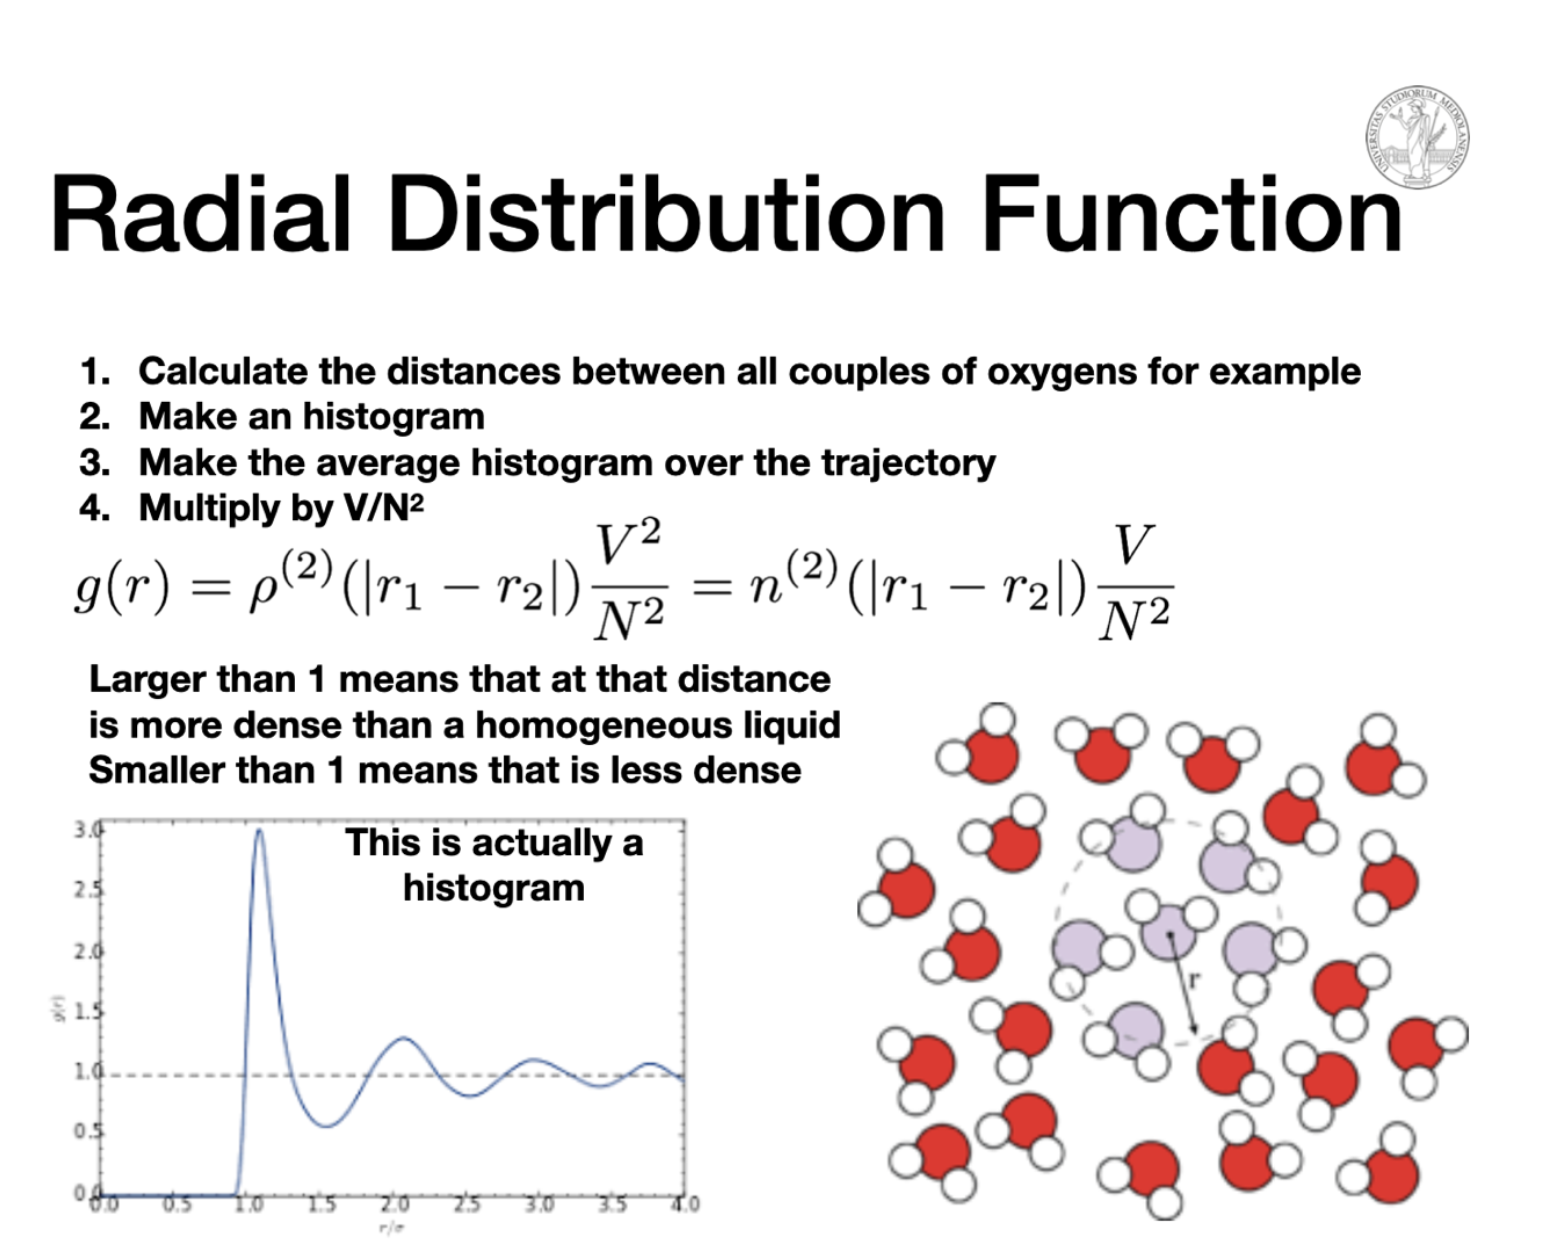

In [ ]:
# we generate a selection of the oxygen atoms
!echo -e 'aOW\nq\n' | gmx make_ndx -f md-water.tpr

In [ ]:
!echo -e "3\n3\n" |gmx rdf -f md-water -s md-water -n index -o rdf_293.xvg

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]

with open('rdf_293.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots()
figure.set_size_inches(18.5, 10.5)

axis.plot(x, y1)
axis.set_ylabel("g(r)")
axis.set_xlabel("r (nm)")
axis.axhline(y=1, color='r', linestyle='--')
plt.show()

## Molecular Dynamics of Alanine Dipeptide in vacuum

This is alanine-dipeptide:

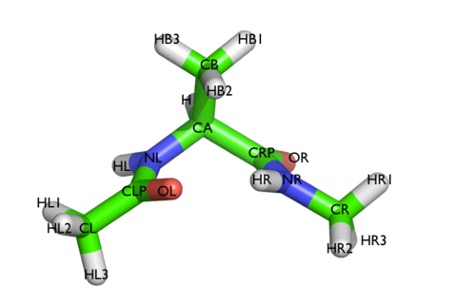

The PDB structure for this system is in MD-examples/alanine-dipeptide, first of all copy the file in your folder.



In [ ]:
%cd {local_path}
%mkdir aladp
%cd aladp
%cp ../../sb/Data/md/inputs/aladp.pdb .

Now, if you remember the steps for beginning an MD simulations they were more or less:

1)	Chose a force-field

2)	Setting the box and the solution conditions

3)	Energy minimization

4)	Simulation

So, from the beginning, the first step is to “translate” the PDB structure in the GROMACS format, while at the same time we set the force-field. This is done interactively using the GROMACS module `pdb2gmx`, here we chose the first force field in the list and we don’t choose any specific model of water because we will run the simulation in vacuum:

### System preparation

In [ ]:
!gmx pdb2gmx -f aladp.pdb -water none -ff amber03

From the output you will see that we have selected the force field “AMBER03”, you can also see some information about the system.

Now in the folder you have some more files:

-	conf.gro: the alanine dipeptide structure in the gromacs format
-	topol.top: a topology file including all the information about the force field
-	posre.itp: this is a file that can be used to restrain the position of the atoms (we will not use it).

Now moving to the second step we need to define the BOX of our simulation


In [ ]:
!gmx editconf -f conf.gro -bt cubic -d 1 -o boxed.gro

We are putting our molecule in a cubic box whose side are at least 1 nm far from the surface of our molecule. boxed.gro is the resulting output file.

At this point one would fill the box with the solution, but we are working in vacuum so we skip this step.

So we prepare the system for energy minimization:


### Energy minimisation

In [ ]:
%cp ../../sb/Data/md/mdps/0-em-steep.mdp em.mdp

In [ ]:
!gmx grompp -f em.mdp -c boxed.gro -p topol.top -o em.tpr -maxwarn 1
!gmx mdrun -deffnm em -v

The first command merges all the information of the em.mdp, boxed.gro and topol.top files into a single file that will be used to run the simulation: em.tpr. In the file em.mdp there are all the details about the simulation algorithms.

The second command executes the energy minimization, this lasts only few steps


Now there is a em.gro file that is the energy minimized structure:

### Molecular dynamics

In [ ]:
%cd {local_path}/aladp
%cp ../../sb/Data/md/mdps/run.mdp .

In [ ]:
!gmx grompp -f run.mdp -c em.gro -p topol.top -o run.tpr
!gmx mdrun -deffnm run -v -nb cpu -ntmpi 1 -ntomp 1

### Visualisation

The simulation will take around 1 minute to perform 10 ns.

To visualise the simulation, you can copy the `run.xtc` and `em.gro` files on your workstation. Open the `em.gro` file with VMD and then load into the `run.xtc` file.

### Analysis

In [ ]:
!gmx chi -f run.xtc -s run.tpr -phi -psi -rama -all

In [ ]:
%ls

This will write a `psiALA2.xvg` and `phiALA2.xvg` files that include the time evolution of the phi and psi angles:

You can plot both as a function of the frame


In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('phiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('psiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2)

axis[0].plot(y1)
axis[0].set_ylabel("PHI")

axis[1].plot(y2)
axis[1].set_ylabel("PSI")
axis[1].set_xlabel("Time (ps)")

plt.show()


or one against the other as in the Ramachandran plot:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('ramaPhiPsiALA2.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

plt.scatter(x,y1)

plt.xlabel('')
plt.ylabel('')

plt.show()

There are also histograms:

In [ ]:
import matplotlib.pyplot as plt
import csv

x=[]
y1=[]
y2=[]

with open('histo-phiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        x.append(float(row.split()[0]))
        y1.append(float(row.split()[1]))

with open('histo-psiALA.xvg', 'r') as file:
    for row in file:
        if row.split()[0] == '#':
          continue
        if row.split()[0] == '@':
          continue
        if row.split()[0] == '&':
          continue
        if row.split()[0] == '@TYPE':
          continue
        y2.append(float(row.split()[1]))


figure, axis = plt.subplots(2)

axis[0].plot(x,y1)
axis[0].set_xlabel("PHI")

axis[1].plot(x,y2)
axis[1].set_xlabel("PSI")

plt.show()